# Correction TP: Bagging, Random Forest, Boosting

### Import

In [1]:
import numpy as np
from scipy.stats import binom
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn import datasets
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Settings

In [2]:
# Seed initialization
np.random.seed(seed=1)

## Theoretical question

### 1. Simple case aggregation

Pour L=10 et p=0.700000, probability of correct classification: 0.901191



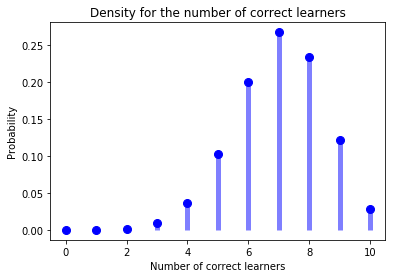

In [3]:
fig, ax = plt.subplots(1, 1)

L, p = 10, 0.7 # 1,5,10,50,100

x = np.arange(0, L + 1, 1)
pmf = binom.pmf(x, L, p);

if L % 2 == 0:
    # choose randomly in case of ties
    prob_succes = pmf[L // 2 + 1:].sum() + pmf[L // 2] / 2.
else:
    # no ties possible
    prob_succes = pmf[L // 2 + 1:].sum()

print("Pour L=%d et p=%f, probability of correct classification: %f\n" % (L,p,prob_succes))

# plot the probability density
ax.plot(x, pmf, 'bo', ms=8, label='binom pmf')
ax.vlines(x, 0, pmf, colors='b', lw=5, alpha=0.5)
plt.title("Density for the number of correct learners")
plt.xlabel("Number of correct learners")
plt.ylabel("Probability")
plt.show()

## Bagging

### 2-6. Implementation of bagging

For tasks 2 - 6, use this skeleton and play around with parameters

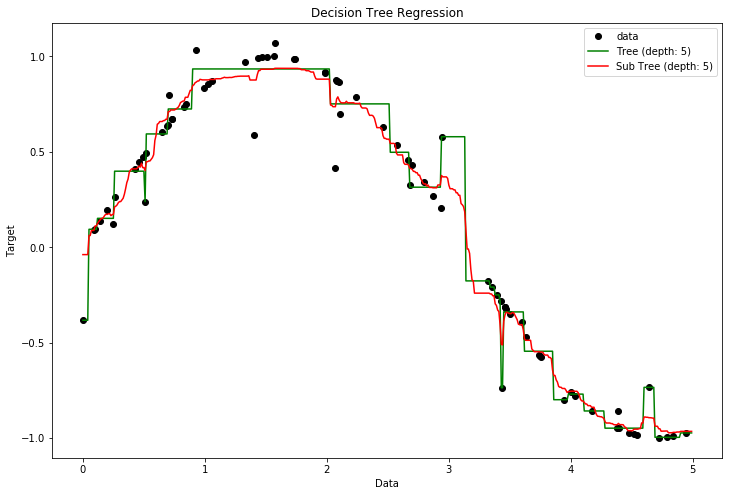

In [4]:
# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 1 * (0.5 - rng.rand(16))
# Set parameters
n_estimators = 100
tree_max_depth = 5
bagging_max_depth = 5
# Initialize and fit regressosr
tree = DecisionTreeRegressor(max_depth=tree_max_depth)
bagging = BaggingRegressor(DecisionTreeRegressor(max_depth=bagging_max_depth),
                           n_estimators=n_estimators, max_samples=0.5,
                           max_features=1.0, bootstrap=True,)
tree.fit(X, y)
bagging.fit(X, y)
# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_tree = tree.predict(X_test)
y_bagging = bagging.predict(X_test)
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(X, y, 'o', c="k", label="data")
plt.plot(X_test, y_tree, c="g", label="Tree (depth: %d)" % tree_max_depth)
plt.plot(X_test, y_bagging, c="r",
         label="Sub Tree (depth: %d)" % bagging_max_depth)
plt.xlabel("Data")
plt.ylabel("Target")
plt.title("Decision Tree Regression")
plt.legend(loc=1, numpoints=1)
plt.show()


## Random forest

### 7. Comparison with SVM

In [5]:
for name, dataset in (('Boston', datasets.load_boston()),
                      ('Diabetes', datasets.load_diabetes()),
                      ('Iris', datasets.load_iris()),
                      ('Digits', datasets.load_digits())
                      ):
    # Shuffle and rescale data
    X, y = shuffle(dataset.data, dataset.target, random_state=0)
    X = X.astype(np.float32)
    X -= X.mean(axis=0)
    X /= X.std(axis=0)
    X[np.isnan(X)] = 0.
    # Fit classification model
    params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2}
    if name == 'Iris' or name == 'Digits':
        rf = RandomForestClassifier(**params)
        svc = svm.SVC(C=1., kernel='linear')
    else:
        rf = RandomForestRegressor(**params)
        svc = svm.SVR(C=1., kernel='linear')
    print("-" * 5, name, "-" * 5)
    # Calculate the score
    for clf in (rf, svc):
        scores = cross_val_score(clf, X, y, cv=7)
        print(str(clf)[:25], '...', "%2.2f - %2.2f" % (scores.mean(),
                                                       scores.std()))

----- Boston -----
RandomForestRegressor(boo ... 0.80 - 0.09
SVR(C=1.0, cache_size=200 ... 0.69 - 0.13
----- Diabetes -----
RandomForestRegressor(boo ... 0.43 - 0.10
SVR(C=1.0, cache_size=200 ... 0.48 - 0.09
----- Iris -----
RandomForestClassifier(bo ... 0.97 - 0.04
SVC(C=1.0, cache_size=200 ... 0.95 - 0.05
----- Digits -----
RandomForestClassifier(bo ... 0.92 - 0.01
SVC(C=1.0, cache_size=200 ... 0.98 - 0.01


### 8. Prediction probabilities on the iris data

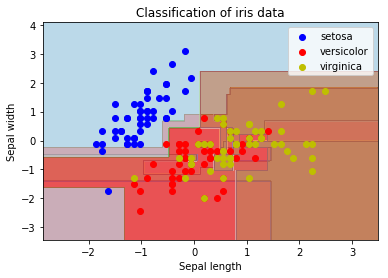

In [6]:
# Parameters
n_estimators = 2
plot_colors = "bry"
plot_step = 0.02
# Load data
iris = load_iris()
X_unscaled, y = iris.data[:, :2], iris.target
# Standardize
X = preprocessing.scale(X_unscaled)
# RF fitting
model = RandomForestClassifier(n_estimators=n_estimators)
clf = model.fit(X, y)
# Plot the decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

plt.figure()
for tree in model.estimators_:
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, alpha=1. / n_estimators, cmap=plt.cm.Paired)
plt.axis("tight")
# Plot the training points
for i, c in zip(range(3), plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=c, label=iris.target_names[i],
                cmap=plt.cm.Paired)
plt.legend(scatterpoints=1)
plt.title("Classification of iris data")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")
plt.show()

### 9. Comparison with single decision tree: score

----- Digits -----
RandomForestClassifier(bootstrap=Tr ... 0.975 - 0.009
DecisionTreeClassifier(class_weight ... 0.317 - 0.006


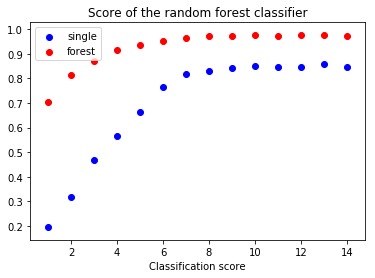

In [7]:
# Load data
dataset = datasets.load_digits()
# Shuffle and rescale data
X, y = shuffle(dataset.data, dataset.target, random_state=0)
X = X.astype(np.float32)
X -= X.mean(axis=0)
X /= X.std(axis=0)
X[np.isnan(X)] = 0.
# Fit classification model
params = {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2}
rf = RandomForestClassifier(**params)
rt = DecisionTreeClassifier(max_depth=2)
# Print scores
print("-" * 5, name, "-" * 5)
for clf in (rf, rt):
    scores = cross_val_score(clf, X, y, cv=6)
    print(str(clf)[:35], '...', "%2.3f - %2.3f" % (scores.mean(), scores.std()))

# Influence of depth on a single tree
depths = range(1, 15)
scores_rt = np.zeros(15)
scores_rf = np.zeros(15)
rt = DecisionTreeClassifier()
params = {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2}
rf = RandomForestClassifier(**params)
# Go through different depths
for i in depths:
    rt.set_params(max_depth=i)
    rf.set_params(max_depth=i)
    scores_rt[i - 1] = cross_val_score(rt, X, y, cv=6).mean()
    scores_rf[i - 1] = cross_val_score(rf, X, y, cv=6).mean()

plt.close()
plt.figure()
plt.title("Score of the random forest classifier")
plt.scatter(depths, scores_rt[:14], c='b', label="single")
plt.scatter(depths, scores_rf[:14], c='r', label="forest")
plt.xlabel("Depth of a tree")
plt.xlabel("Classification score")
plt.legend()

## Boosting

### 14. CV error estimation for AdaBoost on digits data set

In [8]:
# Loop through the tree depth
for idepth in [1,2,10]:
    # Create and fit an AdaBoosted decision tree
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=idepth),
                             algorithm="SAMME", n_estimators=300, random_state=1)

    digits = datasets.load_digits()
    X, y = digits.data, digits.target
    # Shuffle
    X, y = shuffle(X, y, random_state=1)
    # Standardize
    mean, std = X.mean(axis=0), X.std(axis=0)
    X = (X - mean) / std
    X[np.isnan(X)] = 0.
    # Train
    ada.fit(X, y)
    # Obtain and pring score
    scores = cross_val_score(ada, X, y, cv=6)
    print(str(ada)[:19], "tree depth = %d" % idepth, 
          '...', "%2.2f - %2.2f" % (scores.mean(),scores.std()))

AdaBoostClassifier( tree depth = 1 ... 0.85 - 0.03
AdaBoostClassifier( tree depth = 2 ... 0.93 - 0.01
AdaBoostClassifier( tree depth = 10 ... 0.99 - 0.01


### 15-16. Error trend with the number of iteration for AdaBoost

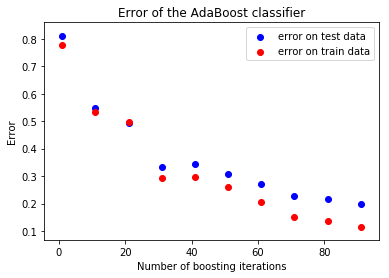

In [9]:
digits = datasets.load_digits()
X, y = digits.data, digits.target
# Shuffle
X, y = shuffle(X, y, random_state=1)
# Standardize
mean, std = X.mean(axis=0), X.std(axis=0)
X = (X - mean) / std
X[np.isnan(X)] = 0.
# Split data
nsample = X.shape[0]
Xtrain = X[:int(nsample / 4), :]
Xtest = X[int(nsample / 4):, :]
ytrain = y[:int(nsample / 4), ]
ytest = y[int(nsample / 4):, ]
# Prepare grid
n_est_grid = np.arange(1, 100, 10)
nn = n_est_grid.shape[0]
# Calculate and plot the errors on train and test data
errors_app = np.zeros(nn)
errors_test = np.zeros(nn)
for i in range(nn):
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                             algorithm="SAMME", n_estimators=n_est_grid[i],
                             random_state=1)
    ada.fit(Xtrain, ytrain)
    ypred = ada.predict(Xtest)
    errors_test[i] = (ypred != ytest).mean()
    errors_app[i] = (ada.predict(Xtrain) != ytrain).mean()

plt.close()
plt.figure()
plt.scatter(n_est_grid, errors_test, c='b', label='error on test data')
plt.scatter(n_est_grid, errors_app, c='r', label='error on train data')
plt.title("Error of the AdaBoost classifier")
plt.xlabel("Number of boosting iterations")
plt.ylabel("Error")
plt.legend()